<figure>
   <IMG SRC="https://mamba-python.nl/images/logo_basis.png" WIDTH=125 ALIGN="right">
</figure>
    
# Congress twitter analysis


This notebook is created for the Mamba python course as an example for big data analysis.

<br>
<br>

<div style="text-align: right"> developed by MAMBA </div>

table of content:<a class="anchor" id="0"></a>
1. [import files](#1)
2. [read twitter data](#2)
3. [read user and party data](#3)
4. [combine datasets](#4)
5. [analyze twitter data per party](#5)
6. [plot results](#6)

## 1. import files<a class="anchor" id="1"></a>

In [1]:
import pandas as pd
#You most likely do not have textblob in you anaconda. 
#If not, go to your anaconda prompt and type pip install textblob (enter)
#The package should install and the ModuleNotFoundError should dissapear
import textblob as tb
import matplotlib.pyplot as plt
import matplotlib
import datetime as dt
import pickle
import numpy as np

C:\Anaconda3\envs\dev\lib\site-packages\pandas\core\computation\expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
#settings (seaborn-v0_8 for style of graphs and maplotlib inline to let the graphs show inside this notebook)
%matplotlib inline
plt.style.use('seaborn-v0_8')


## 2. read twitter data <a class="anchor" id="2"></a>

In [3]:
start_date = dt.datetime(2020,1,1)
end_date   = dt.datetime(2020,1,15) # set for a year to see nicer images
date_range = pd.date_range(start_date, end_date)

In [4]:
twitter_data = pd.DataFrame()
for date in date_range:
    #The twitter data of congress men and women are stored in a file on github. 
    #twitter_data_day loads this data into a pandas dataframe
    print(f"downloading data from {date.strftime('%Y-%m-%d')}")
    twitter_data_day = pd.read_json('https://raw.githubusercontent.com/alexlitel/congresstweets/master/data/%s.json'%date.strftime('%Y-%m-%d'))
    #the time is set as index of the dataframe
    if not twitter_data_day.empty:
        twitter_data_day.index = pd.to_datetime(twitter_data_day.time)
        #for each day the twitter frame of that day is concatenated with the main twitter_data dataframe
        twitter_data = pd.concat([twitter_data, twitter_data_day])
    else:
        print(f"no data available for {date.strftime('%Y-%m-%d')}")

downloading data from 2020-01-01
downloading data from 2020-01-02
downloading data from 2020-01-03
downloading data from 2020-01-04
downloading data from 2020-01-05
downloading data from 2020-01-06
downloading data from 2020-01-07
downloading data from 2020-01-08
downloading data from 2020-01-09
downloading data from 2020-01-10
downloading data from 2020-01-11
downloading data from 2020-01-12
downloading data from 2020-01-13
downloading data from 2020-01-14
downloading data from 2020-01-15


## 3. read user and political party data<a class="anchor" id="3"></a>

In [5]:
#Which twitter user belongs to which political party
user_twitter = pd.read_json('https://raw.githubusercontent.com/alexlitel/congresstweets-automator/master/data/historical-users-filtered.json')

In [6]:
for i, row in user_twitter.iterrows():
    if 'id' in row['accounts'][0].keys():
        user_twitter.loc[i, 'user_id'] = row['accounts'][0]['id']
    if 'screen_name' in row['accounts'][0].keys():
        user_twitter.loc[i, 'screen_name'] = row['accounts'][0]['screen_name']

## 4. combine datasets<a class="anchor" id="4"></a>
link twitter users to political parties

In [7]:
#Make a new column with the political party per twitter message in twitter_data
twitter_data['party'] = twitter_data.screen_name.apply(lambda x: user_twitter[user_twitter.screen_name==x]['party'].values[0] if x in user_twitter.screen_name.values else 'U')

## 5. analyze twitter data per party<a class="anchor" id="5"></a>
analyze the sentiment of the tweets

In [8]:
#make sure the index is sorted and datetime datatype
twitter_data.sort_index(inplace=True)

In [9]:
#textblob is a packages that has a function to evaluate the sentiment of that message. 
#This sentiment.polarity is valued as a float between -1 and 1. 
twitter_data['polarity'] = twitter_data.text.apply(lambda x: tb.Sentence(x).sentiment.polarity)

In [10]:
#make a new dataframe with only relevant data columns
twitter_data_rel = twitter_data[['screen_name','party', 'polarity']]

In [12]:
# write to pickle
with open(r'data\processed_twitter_data.pickle', 'wb') as pfile:
    pickle.dump(twitter_data_rel, pfile)

# load pickle to skip previous time consuming steps
with open(r'data\processed_twitter_data.pickle', 'rb') as pfile:
    twitter_data_rel = pickle.load(pfile)

In [13]:
# get daily average of the polarity per party (decomcrat or republican)
twitter_data_d = twitter_data_rel[twitter_data_rel.party=='D']
twitter_data_r = twitter_data_rel[twitter_data_rel.party=='R']

#Note, in de lines below the 'D' stands for daily instead of 'democrat'. 
#This does not improve readibility, but ah well. 
twitter_data_d_daily_average = twitter_data_d['polarity'].resample('D').mean()
twitter_data_r_daily_average = twitter_data_r['polarity'].resample('D').mean()

In [14]:
# get bandwidth 0f the polarity per party daily ('D') (decomcrat or republican)
upper_percentile = 90
lower_percentile = 10

#With apply we do the operation per row of echt dataframe
twitter_data_d_daily_upper = twitter_data_d['polarity'].resample('D').quantile(upper_percentile/100)
twitter_data_d_daily_lower = twitter_data_d['polarity'].resample('D').quantile(lower_percentile/100)
twitter_data_r_daily_upper = twitter_data_r['polarity'].resample('D').quantile(upper_percentile/100)
twitter_data_r_daily_lower = twitter_data_r['polarity'].resample('D').quantile(lower_percentile/100)

## 6. plot results<a class="anchor" id="6"></a>

In [15]:
#First lets get some statistics 
df = twitter_data_rel[['screen_name', 'polarity']].groupby(['screen_name']).mean()

low_ave_pol = df.polarity.min()
user_low_ave_pol = df[df.polarity==low_ave_pol].index[0]
no_tweets_user = (twitter_data_rel.screen_name==user_low_ave_pol).sum()
print('minimum')
print('lowest, average polarity of twitter users: %.2f'%low_ave_pol)
print('twitter user with lowest average polarity: %s'%user_low_ave_pol)
print("number of tweets by %s : %i"%(user_low_ave_pol, no_tweets_user))
print('\nmaximum')
max_ave_pol = df.polarity.max()
user_max_ave_pol = df[df.polarity==max_ave_pol].index[0]
no_tweets_user = (twitter_data_rel.screen_name==user_max_ave_pol).sum()
print('maximum, average polarity of twitter users: %.2f'%max_ave_pol)
print('twitter user with maximum average polarity: %s'%user_max_ave_pol)
print("number of tweets by %s : %i"%(user_max_ave_pol, no_tweets_user))

minimum
lowest, average polarity of twitter users: -0.50
twitter user with lowest average polarity: JimPressOffice
number of tweets by JimPressOffice : 1

maximum
maximum, average polarity of twitter users: 1.00
twitter user with maximum average polarity: latta4congress
number of tweets by latta4congress : 1


In [16]:
# annotation of these values in our plot
def add_annotation(ax, day, twitter_data_daily_average, 
                   connectionstyle, text, x_dis=-20, y_dis=0.3, facecolor='green', linewidth=None,
                   edgecolor=None):
    '''
    '''
    pol_day_party = twitter_data_daily_average[day:day]['polarity'].values[0]
    ax.annotate(text, 
                xy=(day, pol_day_party), 
                xytext=(day+dt.timedelta(x_dis), pol_day_party+y_dis), 
                fontsize=12,
                arrowprops=dict(arrowstyle="fancy", 
                                facecolor=facecolor, 
                                edgecolor=edgecolor ,
                                lw=linewidth,
                                connectionstyle=connectionstyle))
    return ax

,polarity
party_mod,
Democrat,0.123038
Republican,0.145325
Other,0.135987
Total,0.134045


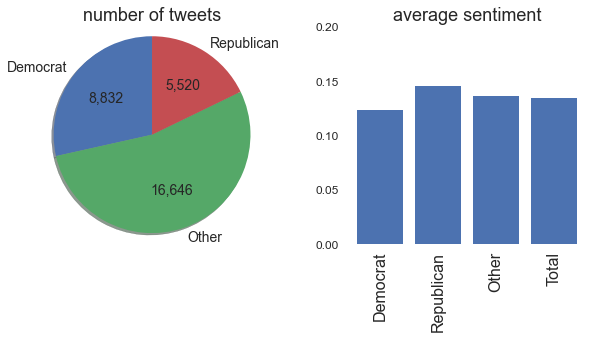

In [18]:
twitter_data_rel.loc[:,'party_mod'] = twitter_data_rel['party']
twitter_data_rel.loc[~twitter_data_rel['party_mod'].isin(['R','D']), 'party_mod'] = 'Other'
twitter_data_rel.loc[twitter_data_rel['party_mod']=='R', 'party_mod'] = 'Republican'
twitter_data_rel.loc[twitter_data_rel['party_mod']=='D', 'party_mod'] = 'Democrat'

plt.rcParams.update({'font.size': 16})
#plt.xticks(rotation=45)

fig, axs = plt.subplots(1, 2, figsize=(10,4))


chart_1 = twitter_data_rel.groupby([twitter_data_rel.party_mod]).count()
total = sum(chart_1['party'])
ax1, ax2  = axs[0], axs[1]
# ax3, ax4 = axs[1, 0], axs[1, 1]
ax1.pie(chart_1['party'].values, labels=chart_1['party'].index,  
        autopct=lambda p: '{:,.0f}'.format(p * total / 100), #explode=[ 0.05, 0.05, 0.05] ,
        shadow=True, startangle=90, textprops={'fontsize': 14})

ax1.set_title('number of tweets', fontsize=18)
ax1.axis('equal')

chart_2 = twitter_data_rel[['polarity','party_mod']].groupby(['party_mod']).mean()
chart_2 = chart_2.reindex(['Democrat', 'Republican', 'Other'])
chart_2.loc['Total']= twitter_data_rel.polarity.mean()


ax2.bar([ 0, 1, 2, 3], chart_2.values[:,0])

ax2.set_xticks(np.arange(-0, 4, 1))
ax2.set_xticklabels(chart_2.index.values, rotation=90)


ax2.tick_params(axis='x', which='major', labelsize=16)

ax2.set_yticks(np.arange(0,0.25,0.05))
ax2.tick_params(axis='y', which='major', labelsize=12)

ax2.patch.set_facecolor('none')
ax2.set_title('average sentiment', fontsize=18);
plt.subplots_adjust(wspace=0.3)
fig.savefig(r'figures/pie_bar_charts.png', bbox_inches='tight')

chart_2

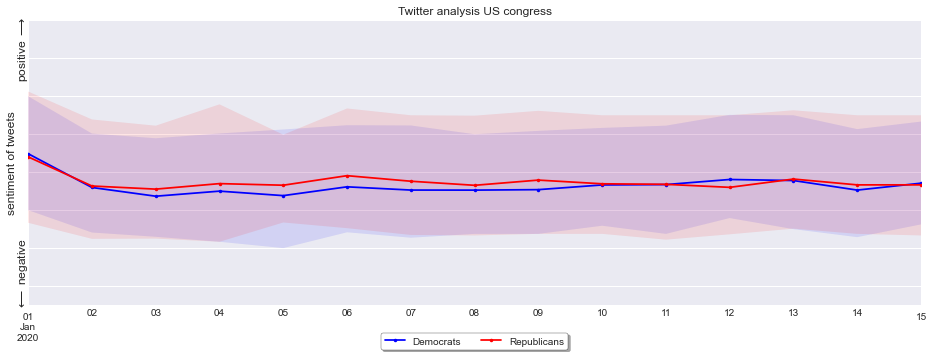

In [19]:
# plot
fig = plt.figure(figsize=(16,16/2.75))
ax = plt.subplot()

# plot average
twitter_data_d_daily_average.plot(ax=ax, linestyle=None, marker='.', color='blue', label='Democrats')
twitter_data_r_daily_average.plot(ax=ax, linestyle=None, marker='.', color='red', label='Republicans')

# plot bandwidth
ax.fill_between(twitter_data_d_daily_upper.index, twitter_data_d_daily_lower.values, 
                twitter_data_d_daily_upper.values, facecolor='blue', alpha=0.1)
ax.fill_between(twitter_data_r_daily_upper.index, twitter_data_r_daily_lower.values, 
                twitter_data_r_daily_upper.values, facecolor='red', alpha=0.1)


# add arrow to some peaks
# ax = add_annotation(ax, dt.datetime(2020,2,17), twitter_data_r_daily_average, "angle3,angleA=90,angleB=0",
#                     "President's day", x_dis=-22)

# ax = add_annotation(ax, dt.datetime(2020,4,12), twitter_data_r_daily_average, "arc3,rad=-0.3",
#                     "Easter", x_dis=-22, facecolor='blue')

# ax = add_annotation(ax, dt.datetime(2020,5,10), twitter_data_r_daily_average, "arc3,rad=-0.3",
#                     "mother's day", x_dis=-25, facecolor='magenta')

# ax = add_annotation(ax, dt.datetime(2020,6,21), twitter_data_r_daily_average, "arc3,rad=-0.3",
#                     "father's day", x_dis=-12, facecolor='yellow')

# ax = add_annotation(ax, dt.datetime(2020,7,4), twitter_data_r_daily_average, "arc3,rad=-0.2",
#                     "independence day", x_dis=2 , facecolor='red', edgecolor='blue', linewidth=1)

# ax = add_annotation(ax, dt.datetime(2020,6,14), twitter_data_r_daily_average, "arc3,rad=-0.2",
#                     "birthday\n Trump", x_dis=-30 , facecolor='red', edgecolor='red', linewidth=1)

# format axes
ax.set_ylim(-0.5,1.0)
ax.set_xlabel('')
ax.set_ylabel('sentiment of tweets', fontsize=12)
ax.set_yticklabels([])

ax.set_xlim(start_date, twitter_data_d_daily_average.index.max())
xmin, xmax = ax.get_xlim()
ymin, ymax = ax.get_ylim()

ax.text(xmin-0.2, ymax-0.3, r'positive $\longrightarrow$', rotation=90, fontsize=12)
ax.text(xmin-0.2, ymin, r'$\longleftarrow$ negative', rotation=90, fontsize=12)

# format legend
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])


# Put a legend below current axis
leg = ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.08),
                frameon=True, facecolor='white', edgecolor='black', shadow=True, ncol=5)

ax.set_title('Twitter analysis US congress')

fig.savefig(r'figures\twitter_analysis_US_congress.png', dpi=300, bbox_inches='tight')